In [68]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import statsmodels.api as sm

In [69]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [70]:
def reReadData():
  df=pd.read_csv('gdrive/My Drive/master_ds_v2_NoNA.csv',header=0, index_col=0, 
                infer_datetime_format=True, parse_dates=['Date'])
  df = df.dropna()
  df = df[train_start:test_end]
  df_train, df_test = df[train_start:train_end],df[train_end:test_end]
  return df, df_train, df_test


def plotProb_train(model):
  bear_regime = 0 if model.params['const[0]']<model.params['const[1]'] else 1

  fig, axes = plt.subplots(2, figsize=(15, 15))

  ax = axes[0]
  ax.plot(df_train.index, df_train['Russell_Close'])
  ax.set(title='Russell_Close')
  
  ax = axes[1]
  ax.plot(df_train.index, model.filtered_marginal_probabilities[bear_regime])
  ax.set(title='Filtered probability of bear_regime')

  plt.show()


def plotProb_test(model):
  bear_regime = 0 if model.params['const[0]']<model.params['const[1]'] else 1

  fig, axes = plt.subplots(2, figsize=(15, 15))

  ax = axes[0]
  ax.plot(df_test.index, df_test['Russell_Close'])
  ax.set(title='Russell_Close')
  
  ax = axes[1]
  ax.plot(df_test.index, model.filtered_marginal_probabilities[bear_regime])
  ax.set(title='Filtered probability of bear_regime')

  plt.show()


def labeling(model,threshold1, threshold2):
  bear_regime = 0 if model.params['const[0]'] < model.params['const[1]'] else 1

  label_filtered = []
  
  for i in model.filtered_marginal_probabilities[bear_regime].values:
    if i >= threshold1:
      app = -1
    elif i >= threshold2:
      app = 0
    else:
      app = 1
    label_filtered.append(app)

  label_filtered= np.array(label_filtered)
  
  return label_filtered


def duration(label):

  duration_bull = []
  duration_static = []
  duration_bear = []

  count,prev,trade = 1,1,0

  for i in label:
    if i == prev:
      count+=1
    else:
      trade+=1
      if prev == 1:
        duration_bull.append(count)
        count = 1
      elif prev == 0:
        duration_static.append(count)
        count = 1
      else:
        duration_bear.append(count)
        count = 1
    prev = i
    
  if prev == 1:
    duration_bull.append(count)
  elif prev == 0:
    duration_static.append(count)
  else:
    duration_bear.append(count)

  duration_bull = pd.DataFrame(duration_bull)
  duration_static = pd.DataFrame(duration_static)
  duration_bear = pd.DataFrame(duration_bear)

  return duration_bull, duration_static, duration_bear,trade


def label_train_logret(label):
  return (df_train['log_ret'] * label).sum()

def label_test_logret(label):
  return (df_test['log_ret'] * label).sum()



def Search_train(model, duration_static, duration_bear):
  threshold1, threshold2, record =0,0,0
  for i in range(1,101):
    for j in range(i):
      label_filtered = labeling(model,i/100, j/100)
      if ( (duration(label_filtered))[1].mean().values >= duration_static ):
        if ( (duration(label_filtered))[2].mean().values >= duration_bear ) :
          if ( (df_train['log_ret'] * label_filtered).sum() >= record ):
            threshold1, threshold2, record = i,j,(df_train['log_ret'] * label_filtered).sum()
  return threshold1/100, threshold2/100



In [71]:
duration_static, duration_bear = 2, 4

## Set time period

In [72]:
train_start = '2010-01-01'
train_end = '2017-12-31'
test_end = '2020-12-31'

## Read data

In [73]:
df,df_train,df_test = reReadData()
print(df,df_train,df_test)

            Russell_Close  ...  hmm1 smoothed state
Date                       ...                     
2010-06-28        2821.11  ...                   -1
2010-06-29        2729.76  ...                   -1
2010-06-30        2703.08  ...                   -1
2010-07-01        2692.74  ...                   -1
2010-07-02        2678.58  ...                   -1
...                   ...  ...                  ...
2020-12-24       12137.42  ...                    1
2020-12-28       12203.97  ...                    1
2020-12-29       12155.89  ...                    1
2020-12-30       12189.07  ...                    1
2020-12-31       12248.16  ...                    1

[2634 rows x 248 columns]             Russell_Close  ...  hmm1 smoothed state
Date                       ...                     
2010-06-28        2821.11  ...                   -1
2010-06-29        2729.76  ...                   -1
2010-06-30        2703.08  ...                   -1
2010-07-01        2692.74  ...       

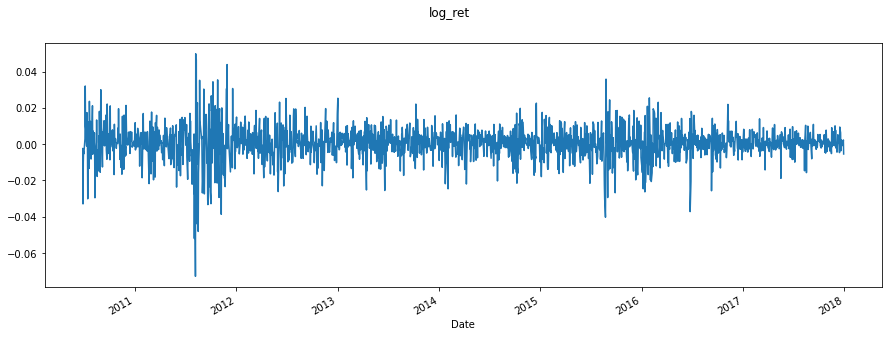

In [74]:
fig = plt.figure(figsize=(15, 5))
fig.suptitle('log_ret')
df_train['log_ret'].plot()
plt.show()

In [75]:
k=15
name = 'log_ret_MA'+str(k)
df[name] = df['log_ret'].rolling(k).mean()
df = df.dropna()
df = df[train_start:test_end]
df_train, df_test = df[train_start:train_end],df[train_end:test_end]
df

,Russell_Close,Russell_Volume,1MTBill,3MTBill,6MTBill,1YTBill,3YTNotes,5YTNotes,10YTNotes,30YTTreasury,T10Y3M,T10Y2Y,3M_USD_LIBOR,TEDRATE,Fed_eff_Rate,WTI_Futures,WTI_Spot,non-farm payroll calendar,change in total non-farm(in thousands),CPI calendar,CPI monthly percent change(%),unemployment rate calendar,Unemployment rate(%),GDP calendar,GDP quarterly percent change(%),Mkt-RF,SMB,HML,RF,FG Close,FG INDEX,SP500_Close,SP500_Volume,POS_RET,POS_SR,State_RET_shifted,State_SR_shifted,Ret_Russell_Close,Ret_1MTBill,Ret_3MTBill,...,lag80_Ret_WTI_Futures,lag80_Ret_WTI_Spot,lag80_Ret_SP500_Close,lag80_Ret_SP500_Volume,lag100_Ret_Russell_Close,lag100_Ret_1MTBill,lag100_Ret_3MTBill,lag100_Ret_6MTBill,lag100_Ret_1YTBill,lag100_Ret_3YTNotes,lag100_Ret_5YTNotes,lag100_Ret_10YTNotes,lag100_Ret_30YTTreasury,lag100_Ret_T10Y3M,lag100_Ret_T10Y2Y,lag100_Ret_3M_USD_LIBOR,lag100_Ret_WTI_Futures,lag100_Ret_WTI_Spot,lag100_Ret_SP500_Close,lag100_Ret_SP500_Volume,lag120_Ret_Russell_Close,lag120_Ret_1MTBill,lag120_Ret_3MTBill,lag120_Ret_6MTBill,lag120_Ret_1YTBill,lag120_Ret_3YTNotes,lag120_Ret_5YTNotes,lag120_Ret_10YTNotes,lag120_Ret_30YTTreasury,lag120_Ret_T10Y3M,lag120_Ret_T10Y2Y,lag120_Ret_3M_USD_LIBOR,lag120_Ret_WTI_Futures,lag120_Ret_WTI_Spot,lag120_Ret_SP500_Close,lag120_Ret_SP500_Volume,log_ret,hmm1 filtered state,hmm1 smoothed state,log_ret_MA15
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-07-19,2801.32,1.224432e+09,0.150,0.160,0.200,0.262,0.936,1.688,2.945,3.969,2.82,2.38,0.51781,0.35,0.19,76.54,76.46,0.0,-139.0,0.0,0.0,0.0,9.5,0.0,3.0,0.54,-0.16,-0.21,0.001,123.9707,2.8931,1071.25,4.089500e+09,1,1,0,1,-0.005844,0.013333,-0.050000,...,80.61,80.23,1167.72,4.705750e+09,2868.02,0.076,0.122,0.193,0.328,1.410,2.348,3.684,4.619,3.58,2.83,0.25194,80.00,80.33,1105.24,4.168360e+09,2824.10,0.018,0.063,0.137,0.290,1.378,2.339,3.610,4.543,3.58,2.78,0.24875,74.71,74.66,1092.17,4.731910e+09,0.005861,-1,-1,-0.000631
2010-07-20,2835.97,1.452886e+09,0.152,0.162,0.208,0.262,0.931,1.673,2.932,3.972,2.82,2.37,0.51250,0.35,0.18,77.44,76.95,0.0,-139.0,0.0,0.0,0.0,9.5,0.0,3.0,1.23,0.66,0.06,0.001,120.8760,-0.0550,1083.48,4.713280e+09,1,1,0,1,-0.012218,-0.013158,-0.012346,...,80.53,80.16,1165.73,5.668900e+09,2864.34,0.084,0.119,0.183,0.305,1.367,2.347,3.652,4.593,3.51,2.82,0.25194,78.17,78.34,1102.94,4.521130e+09,2837.79,0.008,0.068,0.150,0.290,1.353,2.313,3.597,4.533,3.58,2.76,0.24875,73.67,73.75,1097.50,5.319120e+09,0.012293,-1,-1,0.000350
2010-07-21,2798.42,1.577911e+09,0.162,0.162,0.198,0.259,0.920,1.678,2.936,3.954,2.74,2.32,0.50625,0.35,0.18,76.56,76.46,0.0,-139.0,0.0,0.0,0.0,9.5,0.0,3.0,-1.30,-0.38,-0.44,0.001,119.6534,-2.5354,1069.59,4.747180e+09,1,1,0,1,0.013418,-0.061728,0.000000,...,80.00,80.14,1166.59,4.708420e+09,2867.44,0.099,0.132,0.190,0.308,1.351,2.312,3.621,4.557,3.48,2.80,0.25169,79.66,79.63,1104.49,3.945190e+09,2802.54,0.018,0.086,0.152,0.305,1.426,2.427,3.662,4.579,3.60,2.81,0.24875,73.64,73.89,1084.53,5.452400e+09,-0.013329,-1,-1,0.001656
2010-07-22,2865.35,1.545914e+09,0.155,0.160,0.198,0.254,0.925,1.685,2.933,3.933,2.80,2.36,0.49781,0.34,0.18,79.30,79.23,0.0,-139.0,0.0,0.0,0.0,9.5,0.0,3.0,2.37,1.25,0.58,0.001,121.7548,-2.7616,1093.67,4.826900e+09,1,1,0,1,-0.023358,0.045161,0.012500,...,82.17,82.52,1173.22,4.375580e+09,2901.12,0.089,0.129,0.190,0.310,1.329,2.298,3.624,4.580,3.48,2.81,0.25169,78.70,78.84,1115.71,3.847640e+09,2773.42,0.015,0.081,0.155,0.300,1.413,2.407,3.660,4.554,3.55,2.81,0.24906,72.89,72.67,1073.87,5.412850e+09,0.023636,-1,-1,0.003887
2010-07-23,2894.01,1.543022e+09,0.152,0.157,0.203,0.259,0.917,1.683,2.955,3.982,2.86,2.42,0.49313,0.33,0.19,78.98,78.87,0.0,-139.0,0.0,0.0,0.0,9.5,0.0,3.0,1.05,1.49,-0.27,0.001,122.6240,-1.2485,1102.66,4.524570e+09,1,1,0,1,-0.009903,0.019737,0.019108,...,82.37,82.55,1173.27,4.085000e+09,2911.25,0.084,0.132,0.190,0.302,1.337,2.302,3.644,4.598,3.48,2.82,0.25194,79.68,79.65,1118.31,4.134680e+09,2813.77,0.041,0.084,0.167,0.308,1.394,2.380,3.656,4.561,3.58,

## Three regimes, common variance

In [76]:
hmm0 = sm.tsa.MarkovRegression(endog=df_train[name], k_regimes=3,trend='c')
hmm0_results = hmm0.fit(search_reps = 100)
print(hmm0_results.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                        Markov Switching Model Results                        
Dep. Variable:           log_ret_MA15   No. Observations:                 1870
Model:               MarkovRegression   Log Likelihood                9692.571
Date:                Wed, 09 Feb 2022   AIC                         -19365.142
Time:                        19:53:37   BIC                         -19309.805
Sample:                             0   HQIC                        -19344.754
                               - 1870                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0043      0.000    -26.602      0.000      -0.005      -0.004
                             Regime 1 parameters    

Note that the transition prob. from bear to static and from bull to static are too high.

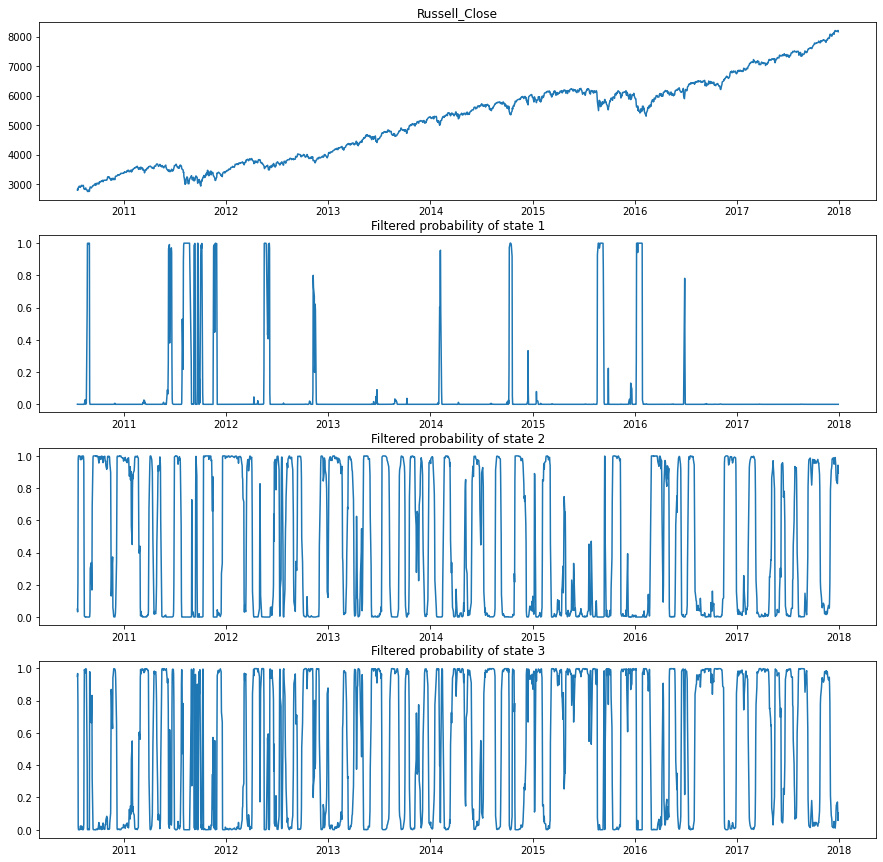

In [77]:
fig, axes = plt.subplots(4, figsize=(15, 15))

ax = axes[0]
ax.plot(df_train.index, df_train['Russell_Close'])
ax.set(title='Russell_Close')
 
ax = axes[1]
ax.plot(df_train.index, hmm0_results.filtered_marginal_probabilities[0])
ax.set(title='Filtered probability of state 1')
 
ax = axes[2]
ax.plot(df_train.index, hmm0_results.filtered_marginal_probabilities[1])
ax.set(title='Filtered probability of state 2')

ax = axes[3]
ax.plot(df_train.index, hmm0_results.filtered_marginal_probabilities[2])
ax.set(title='Filtered probability of state 3')

plt.show()


## Two regimes, switching mean and variance

In [78]:
hmm1 = sm.tsa.MarkovRegression(endog=df_train[name], k_regimes=2,trend='c',
                                    switching_variance=True)
hmm1_results = hmm1.fit(search_reps = 100)
print(hmm1_results.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                        Markov Switching Model Results                        
Dep. Variable:           log_ret_MA15   No. Observations:                 1870
Model:               MarkovRegression   Log Likelihood                9408.059
Date:                Wed, 09 Feb 2022   AIC                         -18804.118
Time:                        19:53:40   BIC                         -18770.916
Sample:                             0   HQIC                        -18791.885
                               - 1870                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0014      0.000    -11.259      0.000      -0.002      -0.001
sigma2      3.368e-06   3.58e-07      9.420      0.0

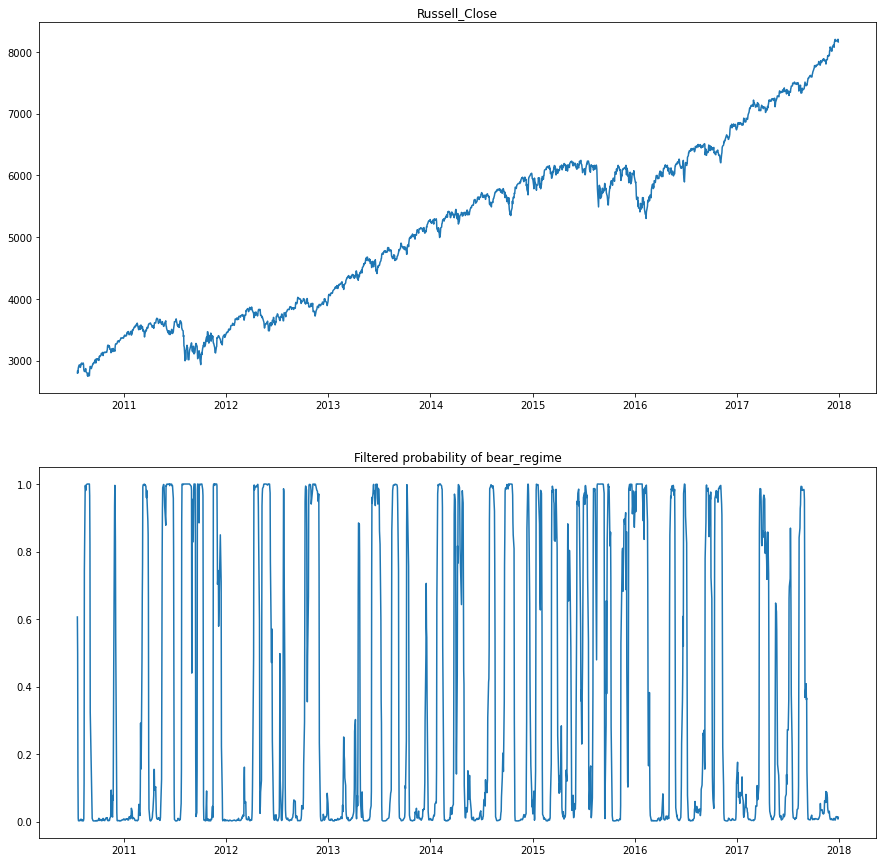

In [79]:
plotProb_train(hmm1_results)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


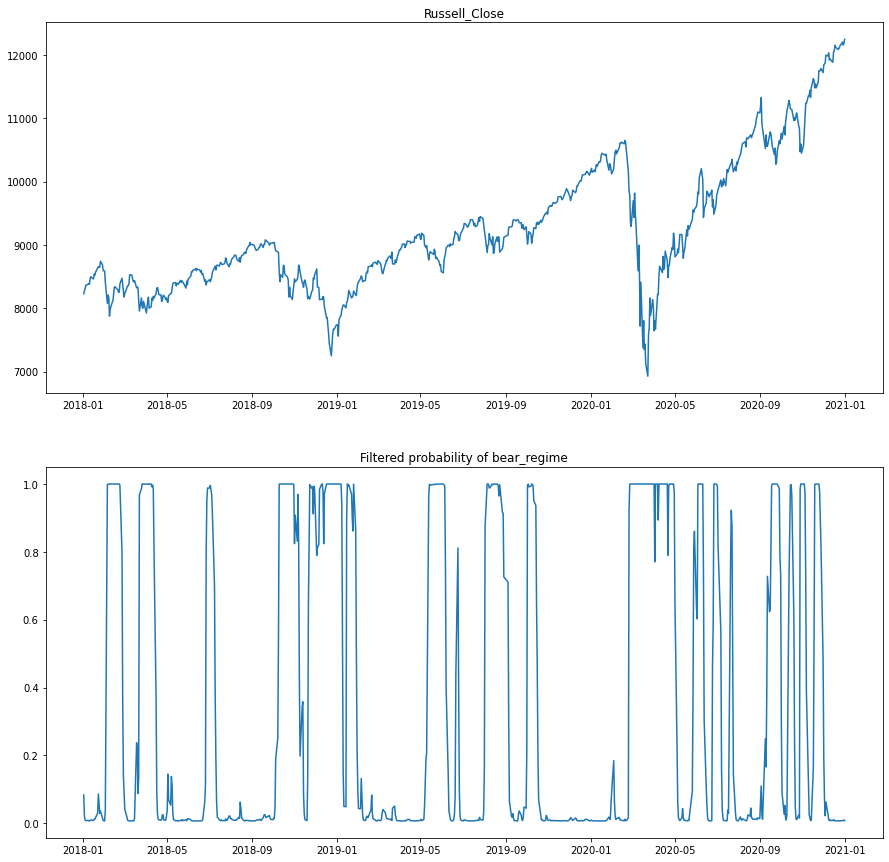

In [80]:
#using the same probability filter constructed from the training set
hmm1_test = sm.tsa.MarkovRegression(endog=df_test[name], k_regimes=2,trend='c',
                                    switching_variance=True)
hmm1_test_results = hmm1_test.fit(start_params = hmm1_results.params, maxiter = 0)
plotProb_test(hmm1_test_results)

In [81]:
t1,t2 = Search_train(hmm1_results, duration_static, duration_bear)
print(t1,t2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:112: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


0.99 0.94


In [82]:
label_filtered = labeling(hmm1_results,t1,t2)
print((duration(label_filtered))[0].mean())
print((duration(label_filtered))[1].mean())
print((duration(label_filtered))[2].mean())
print((duration(label_filtered))[3])
print(df_train['log_ret'].sum(), label_train_logret(label_filtered))

0    27.037037
dtype: float64
0    2.085366
dtype: float64
0    5.333333
dtype: float64
180
1.0563283531096594 1.9191405262411119


In [83]:
np.histogram(label_filtered)

(array([ 240,    0,    0,    0,    0,  171,    0,    0,    0, 1459]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]))

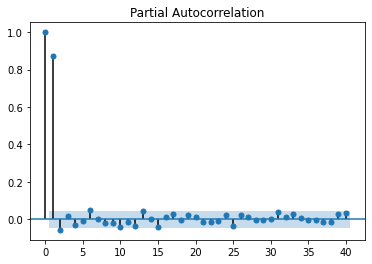

In [84]:
sm.graphics.tsa.plot_pacf(label_filtered, lags=40)
plt.show()

In [85]:
sm.tsa.pacf(label_filtered)

array([ 1.00000000e+00,  8.74278702e-01, -5.82531974e-02,  1.84782109e-02,
       -2.94749667e-02, -8.46922374e-03,  4.98768737e-02, -8.11174940e-04,
       -2.03641922e-02, -2.02535571e-02, -4.46961202e-02, -1.62853219e-02,
       -3.73522799e-02,  4.17420233e-02,  1.30384057e-03, -4.33307021e-02,
        1.00059488e-02,  2.82159530e-02, -6.63353238e-03,  2.17017804e-02,
        1.24598550e-02, -1.73003836e-02, -1.34502732e-02, -9.14142914e-03,
        1.99450733e-02, -3.91441953e-02,  2.14852191e-02,  8.62386512e-03,
       -5.14715988e-03, -5.12298391e-03, -6.99248580e-04,  3.96807634e-02,
        8.59952545e-03,  2.53588079e-02,  6.95298905e-03, -5.26677013e-03,
       -5.53956871e-03, -1.80502252e-02, -1.69599233e-02,  2.55372812e-02,
        3.09508391e-02])

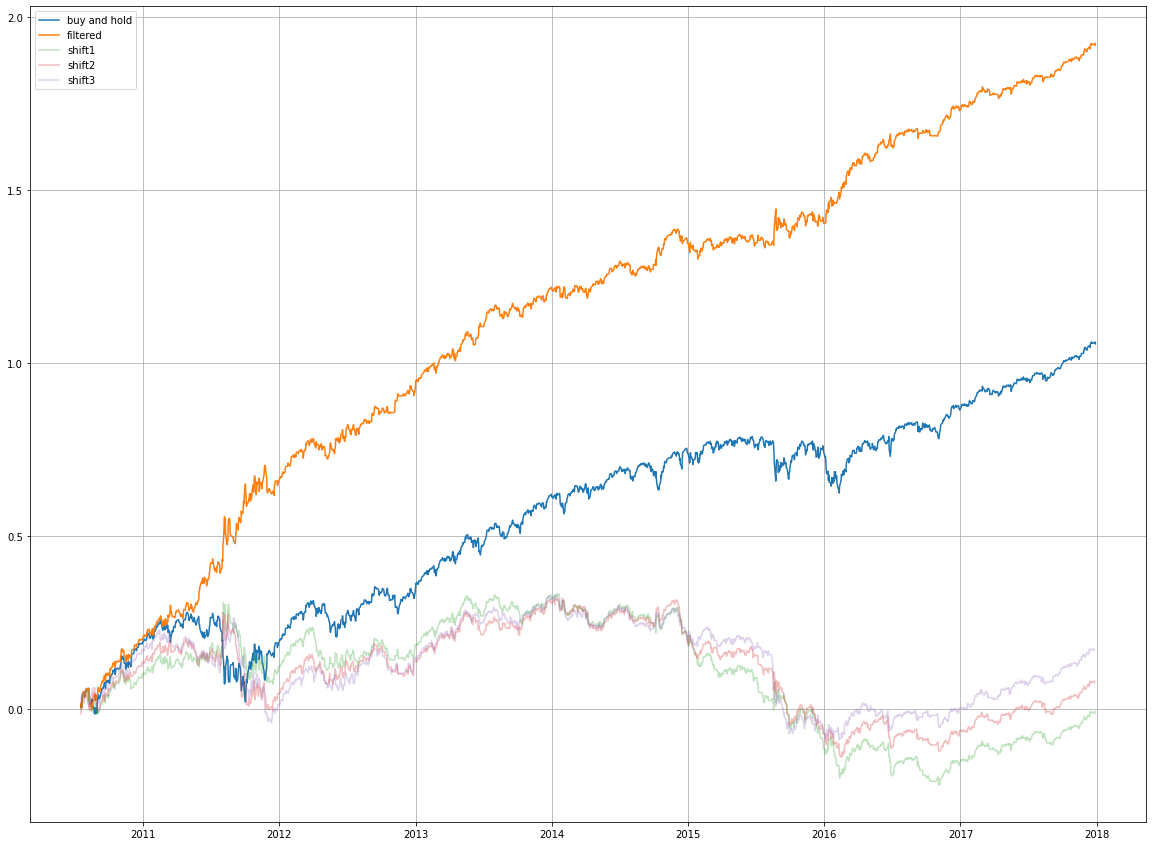

In [86]:
# training set plot

fig, ax = plt.subplots(figsize=(20, 15))

#ax.plot(df_train.index, np.abs(df_train['log_ret']).cumsum(),label="best")
ax.plot(df_train.index, df_train['log_ret'].cumsum(),label="buy and hold")
ax.plot(df_train.index, (df_train['log_ret'] * label_filtered).cumsum(),label = "filtered")
ax.plot(df_train.index, (df_train['log_ret'].shift(-1) * label_filtered).cumsum(),label = "shift1",alpha=0.3)
ax.plot(df_train.index, (df_train['log_ret'].shift(-2) * label_filtered).cumsum(),label = "shift2",alpha=0.3)
ax.plot(df_train.index, (df_train['log_ret'].shift(-3) * label_filtered).cumsum(),label = "shift3",alpha=0.3)
ax.grid(True)
ax.legend()

plt.show()

In [87]:
label_filtered = labeling(hmm1_test_results,t1,t2)
print((duration(label_filtered))[0].mean())
print((duration(label_filtered))[1].mean())
print((duration(label_filtered))[2].mean())
print((duration(label_filtered))[3])
print(df_test['log_ret'].sum(), label_test_logret(label_filtered))

0    22.32
dtype: float64
0    1.190476
dtype: float64
0    6.461538
dtype: float64
71
0.3971813455377167 0.6046356050679822


In [88]:
np.histogram(label_filtered)

(array([168,   0,   0,   0,   0,  25,   0,   0,   0, 557]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]))

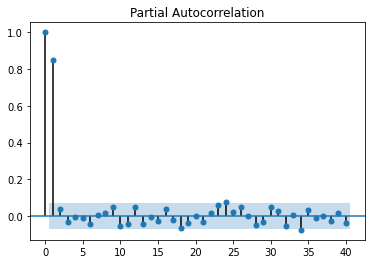

array([ 1.        ,  0.84970743,  0.04137955, -0.02870616, -0.00636217,
       -0.00936419, -0.04029788,  0.00880796,  0.01985567,  0.0498165 ,
       -0.05535623, -0.04005696,  0.05242988, -0.04040583, -0.00184892,
       -0.02785949,  0.03937807, -0.02155747, -0.06260675, -0.03425689,
        0.00112642, -0.02974601,  0.01925706,  0.06084251,  0.08001964,
        0.02307514,  0.04823359,  0.00177648, -0.04638861, -0.02859018,
        0.048332  ,  0.0310706 , -0.05256114,  0.00851174, -0.07419048,
        0.0317213 , -0.00694162,  0.00152156, -0.02303504,  0.01883187,
       -0.03645601])

In [89]:
sm.graphics.tsa.plot_pacf(label_filtered, lags=40)
plt.show()
sm.tsa.pacf(label_filtered)

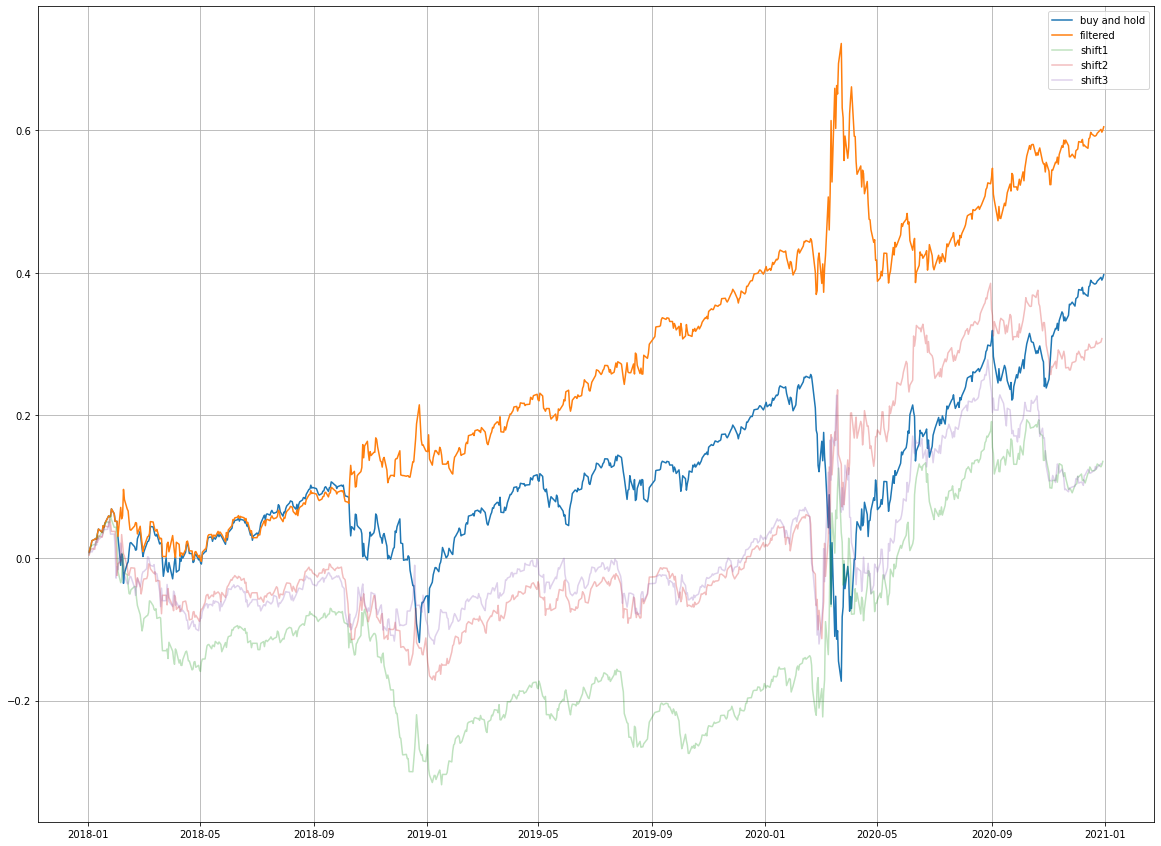

In [90]:
# testing set plot

fig, ax = plt.subplots(figsize=(20, 15))

ax.plot(df_test.index, df_test['log_ret'].cumsum(),label="buy and hold")
ax.plot(df_test.index, (df_test['log_ret'] * label_filtered).cumsum(),label = "filtered")
ax.plot(df_test.index, (df_test['log_ret'].shift(-1) * label_filtered).cumsum(),label = "shift1",alpha=0.3)
ax.plot(df_test.index, (df_test['log_ret'].shift(-2) * label_filtered).cumsum(),label = "shift2",alpha=0.3)
ax.plot(df_test.index, (df_test['log_ret'].shift(-3) * label_filtered).cumsum(),label = "shift3",alpha=0.3)
ax.grid(True)
ax.legend()

plt.show()

## Two regimes, switching mean and variance with other dependent variables in transition prob.

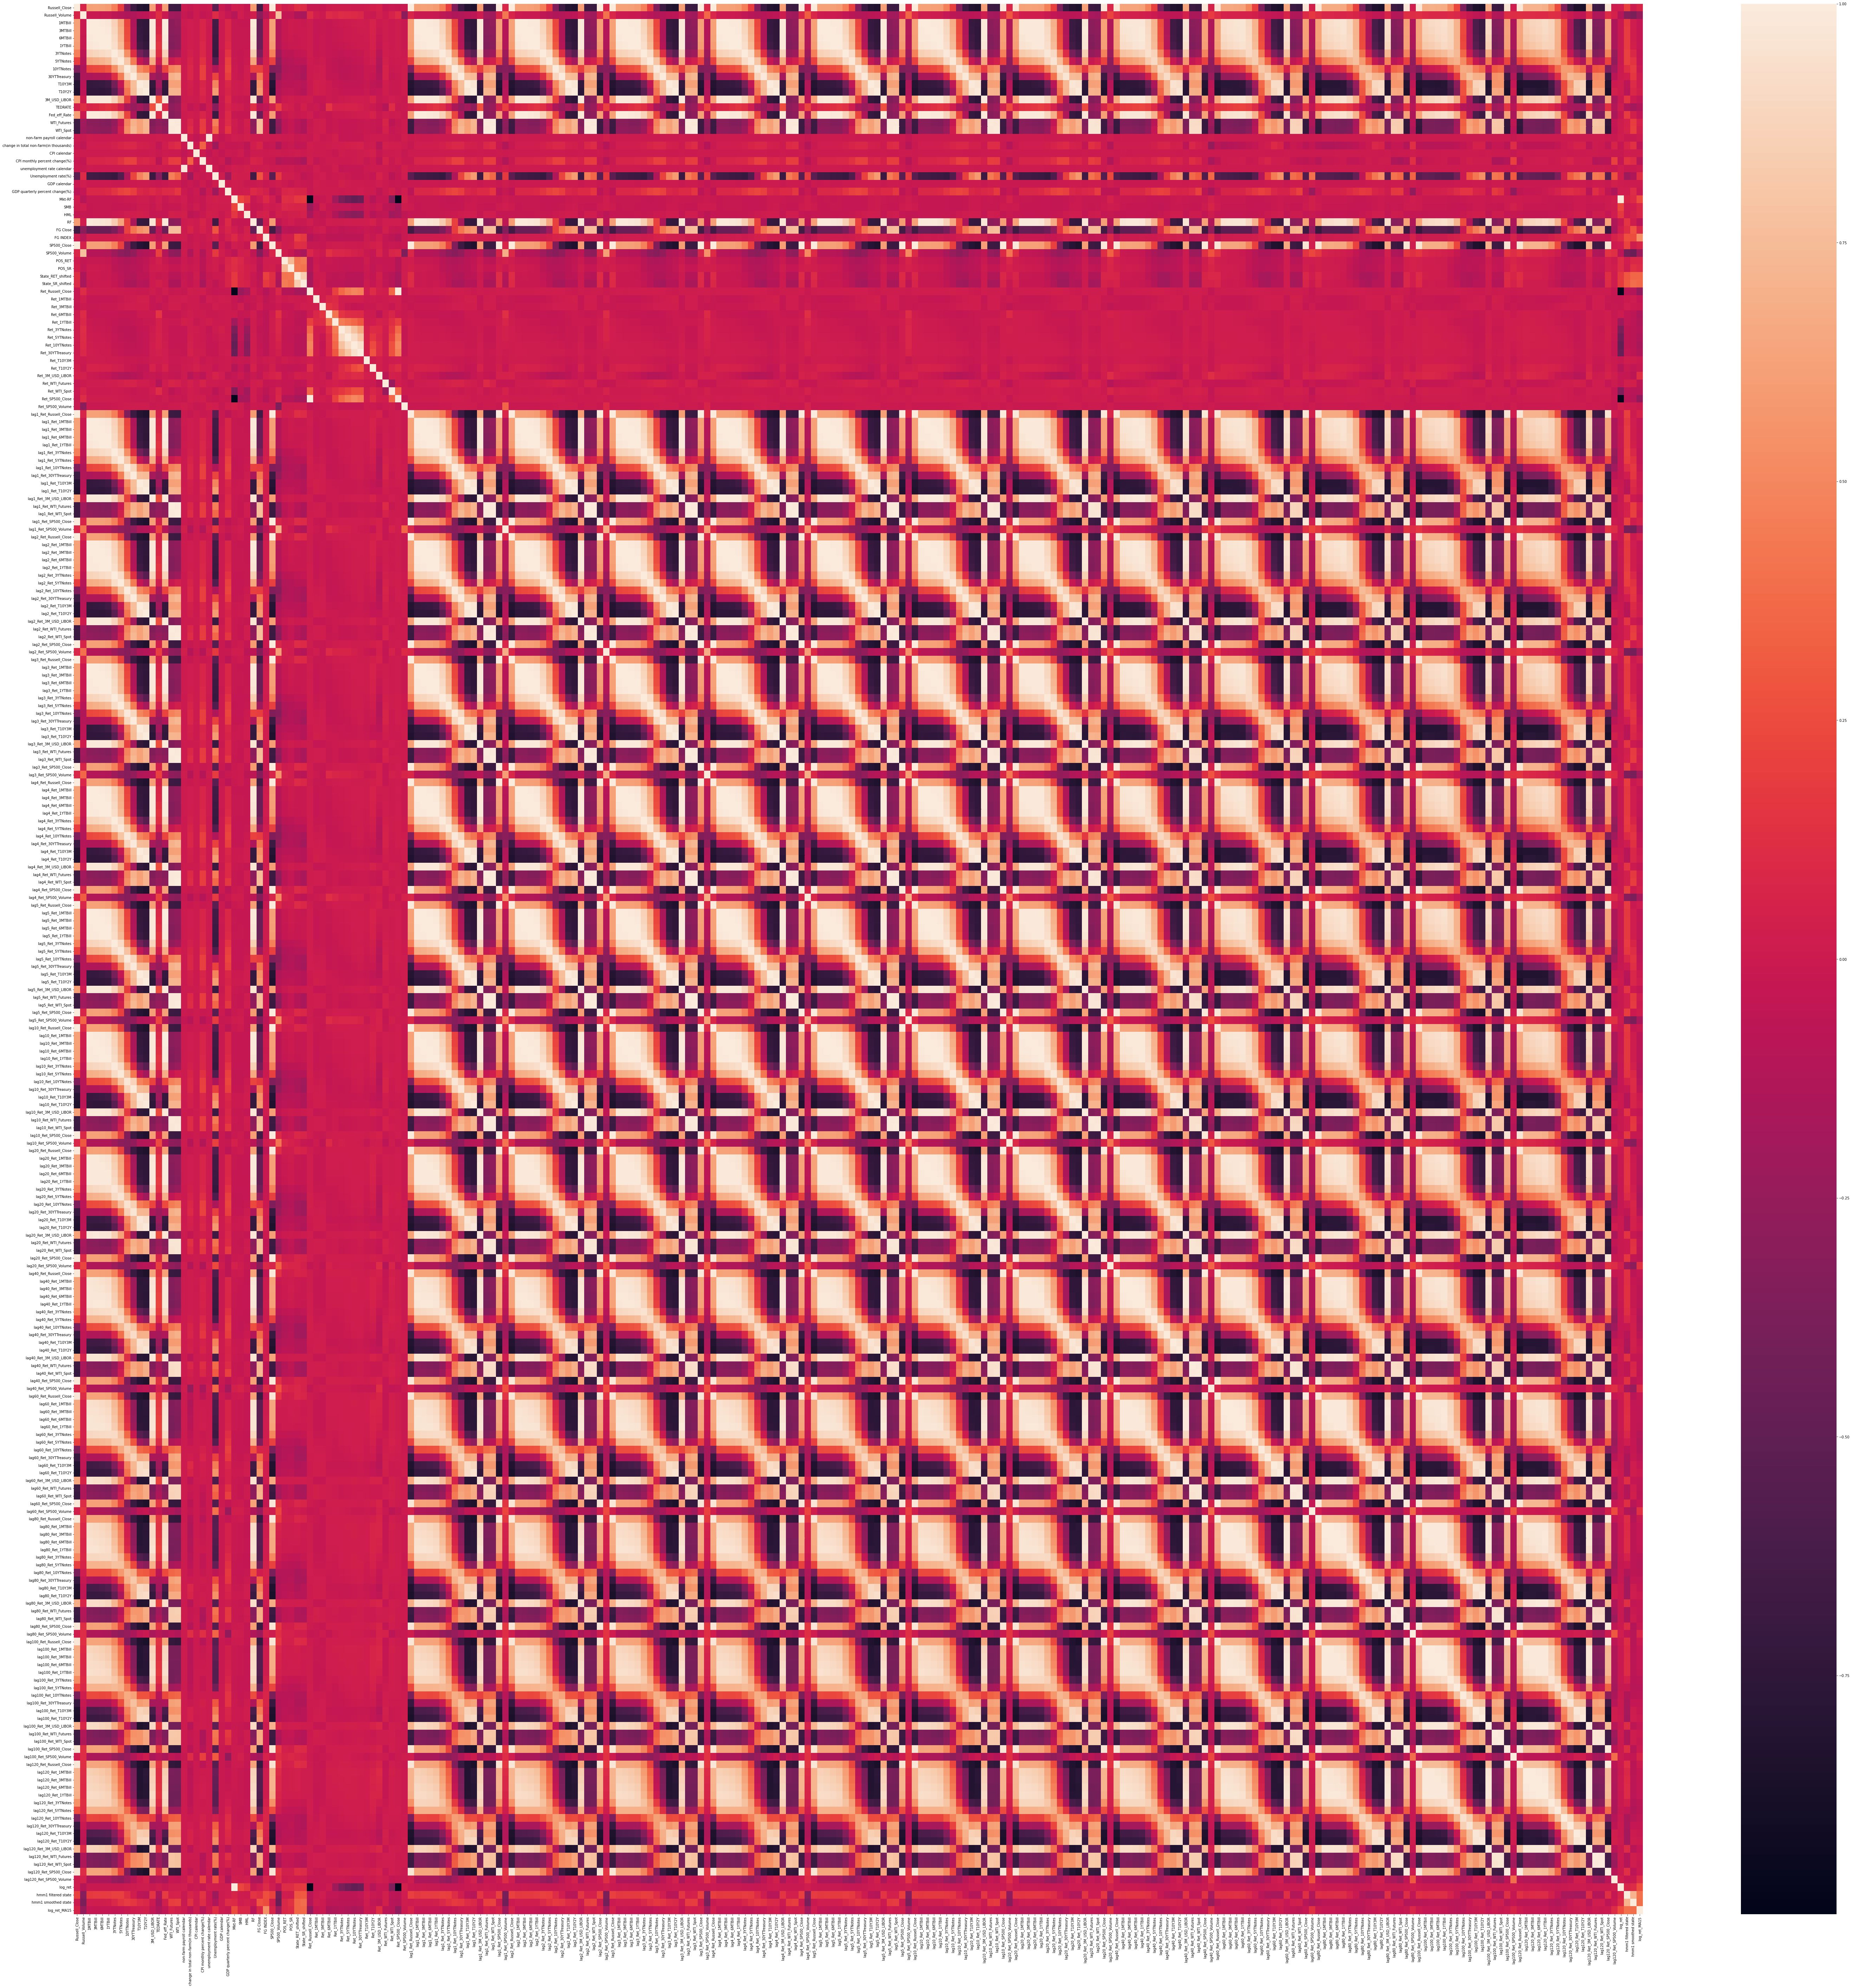

In [91]:
import seaborn as sns
%matplotlib inline

Var_Corr = df.corr()

# plot the heatmap and annotation on it
fig, ax = plt.subplots(figsize=(100,100)) 
sns.heatmap(Var_Corr, xticklabels=Var_Corr.columns, yticklabels=Var_Corr.columns)

In [92]:
for i,j in zip (df[df.columns.to_list()].apply(lambda x: x.autocorr()) , df.columns):
  print(j,i)

Russell_Close 0.9994063414448008
Russell_Volume 0.34651912178130595
1MTBill 0.999472613935737
3MTBill 0.9997363429109375
6MTBill 0.9997746025858489
1YTBill 0.9997104739203516
3YTNotes 0.9987019865788619
5YTNotes 0.9975686408191456
10YTNotes 0.9970814138967501
30YTTreasury 0.9975031536329736
T10Y3M 0.998440584648958
T10Y2Y 0.9989758025358334
3M_USD_LIBOR 0.999866893116033
TEDRATE 0.9894825737464785
Fed_eff_Rate 0.9991761001784948
WTI_Futures 0.9965252956384263
WTI_Spot 0.9985539645044987
non-farm payroll calendar -0.050120288692862794
change in total non-farm(in thousands) 0.9488829879536989
CPI calendar -0.04927884615384618
CPI monthly percent change(%) 0.9706179978372397
unemployment rate calendar -0.050120288692862794
Unemployment rate(%) 0.9953316315956986
GDP calendar -0.007843677549313637
GDP quarterly percent change(%) 0.9790780322363467
Mkt-RF -0.1487863631543013
SMB -0.05240390163493254
HML 0.05423281405453904
RF 0.9983311394280596
FG Close 0.9964882209374576
FG INDEX 0.9581391

In [93]:
# dependent variables used for transition prob.
# hmm1 smoothed state is not measurable; others contain nan

df_train_tvtp = df_train.drop( columns= ['hmm1 smoothed state','Ret_1MTBill','Ret_T10Y3M', 'Ret_T10Y2Y','POS_RET','POS_SR','State_RET_shifted','State_SR_shifted'])
df_train_tvtp = df_train_tvtp.dropna()

mean,std = df_train_tvtp.mean(),df_train_tvtp.std()

df_train_tvtp = (df_train_tvtp-df_train_tvtp.mean())/df_train_tvtp.std()
df_train_tvtp['ones'] = 1
df_train_tvtp

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  # Remove the CWD from sys.path while we load stuff.


,Russell_Close,Russell_Volume,1MTBill,3MTBill,6MTBill,1YTBill,3YTNotes,5YTNotes,10YTNotes,30YTTreasury,T10Y3M,T10Y2Y,3M_USD_LIBOR,TEDRATE,Fed_eff_Rate,WTI_Futures,WTI_Spot,non-farm payroll calendar,change in total non-farm(in thousands),CPI calendar,CPI monthly percent change(%),unemployment rate calendar,Unemployment rate(%),GDP calendar,GDP quarterly percent change(%),Mkt-RF,SMB,HML,RF,FG Close,FG INDEX,SP500_Close,SP500_Volume,Ret_Russell_Close,Ret_3MTBill,Ret_6MTBill,Ret_1YTBill,Ret_3YTNotes,Ret_5YTNotes,Ret_10YTNotes,...,lag80_Ret_WTI_Futures,lag80_Ret_WTI_Spot,lag80_Ret_SP500_Close,lag80_Ret_SP500_Volume,lag100_Ret_Russell_Close,lag100_Ret_1MTBill,lag100_Ret_3MTBill,lag100_Ret_6MTBill,lag100_Ret_1YTBill,lag100_Ret_3YTNotes,lag100_Ret_5YTNotes,lag100_Ret_10YTNotes,lag100_Ret_30YTTreasury,lag100_Ret_T10Y3M,lag100_Ret_T10Y2Y,lag100_Ret_3M_USD_LIBOR,lag100_Ret_WTI_Futures,lag100_Ret_WTI_Spot,lag100_Ret_SP500_Close,lag100_Ret_SP500_Volume,lag120_Ret_Russell_Close,lag120_Ret_1MTBill,lag120_Ret_3MTBill,lag120_Ret_6MTBill,lag120_Ret_1YTBill,lag120_Ret_3YTNotes,lag120_Ret_5YTNotes,lag120_Ret_10YTNotes,lag120_Ret_30YTTreasury,lag120_Ret_T10Y3M,lag120_Ret_T10Y2Y,lag120_Ret_3M_USD_LIBOR,lag120_Ret_WTI_Futures,lag120_Ret_WTI_Spot,lag120_Ret_SP500_Close,lag120_Ret_SP500_Volume,log_ret,hmm1 filtered state,log_ret_MA15,ones
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-07-19,-1.672078,0.384488,-0.116400,-0.178341,-0.263351,-0.309893,0.160109,0.647653,1.393787,1.380912,1.277494,1.229333,0.046976,0.592241,-0.277096,0.061012,0.058407,-0.223484,-3.525707,-0.222163,-0.702567,-0.223484,1.596576,-0.183582,0.820645,0.521673,-0.313815,-0.442655,0.314187,-1.845973,0.556652,-1.721137,0.593114,-0.577591,-0.109066,-0.265657,-0.357834,-0.057321,-0.261752,-0.315904,...,0.189902,0.174419,-1.388918,1.145092,-1.508183,-0.296015,-0.181559,-0.162470,0.027610,1.528744,2.041263,2.443679,2.186835,2.287622,1.856576,-0.712240,0.152240,0.166726,-1.514904,0.487721,-1.515846,-0.605061,-0.437950,-0.369975,-0.079461,1.453092,1.973219,2.216415,1.990724,2.216685,1.725571,-0.719878,-0.085846,-0.087511,-1.520957,1.126796,0.576034,-1.833401,-0.577687,1
2010-07-20,-1.647465,1.059569,-0.109333,-0.172047,-0.240336,-0.309893,0.147399,0.612545,1.366537,1.386226,1.277494,1.212151,0.031814,0.592241,-0.308948,0.098234,0.078673,-0.223484,-3.525707,-0.222163,-0.702567,-0.223484,1.596576,-0.183582,0.820645,1.272657,1.284390,0.136067,0.314187,-1.993984,0.019459,-1.691971,1.439748,-1.269493,-0.056975,-0.387943,-0.011012,0.100846,0.237491,0.179472,...,0.186540,0.171477,-1.393827,2.286012,-1.510918,-0.255083,-0.194872,-0.202135,-0.055328,1.410689,2.039056,2.385541,2.144689,2.172896,1.839179,-0.712240,0.074667,0.082352,-1.520606,0.905226,-1.505589,-0.662259,-0.413397,-0.314446,-0.079461,1.384064,1.916887,2.193485,1.974859,2.216685,1.690966,-0.719878,-0.130249,-0.126374,-1.507657,1.816090,1.275690,-1.833401,-0.103669,1
2010-07-21,-1.674138,1.429018,-0.074000,-0.172047,-0.269105,-0.317868,0.119437,0.624248,1.374922,1.354344,1.141025,1.126239,0.013968,0.592241,-0.308948,0.061839,0.058407,-0.223484,-3.525707,-0.222163,-0.702567,-0.223484,1.596576,-0.183582,0.820645,-1.480952,-0.742601,-0.935639,0.314187,-2.052458,-0.432512,-1.725096,1.485759,1.513188,-0.039895,0.420239,0.199492,0.239602,-0.096574,-0.076324,...,0.164267,0.170636,-1.391706,1.148255,-1.508614,-0.178336,-0.137184,-0.174370,-0.044510,1.366761,1.961826,2.329220,2.086333,2.123728,1.804384,-0.713146,0.137827,0.137046,-1.516763,0.223598,-1.531999,-0.605061,-0.325007,-0.305903,-0.021979,1.585627,2.163880,2.308134,2.047838,2.249036,1.777478,-0.719878,-0.131530,-0.120395,-1.540022,1.972540,-1.511232,-1.833401,0.527468,1
2010-07-22,-1.626596,1.334467,-0.098733,-0.178341,-0.269105,-0.331159,0.132147,0.640631,1.368633,1.317148,1.243376,1.194968,-0.010132,0.499354,-0.308948,0.175159,0.172975,-0.223484,-3.525707,-0.222163,-0.702567,-0.223484,1.596576,-0.183582,0.820645,2.513414,2.434318,1.250641,

In [94]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
principalComponents = pca.fit_transform(df_train_tvtp)
principalDf_train = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2','principal component 3','principal component 4','principal component 5'])
principalDf_train

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5
0,-8.072309,12.125451,0.521612,9.856910,-1.655473
1,-8.035671,12.206043,0.609904,10.045716,-2.046693
2,-8.023301,11.943607,0.606103,10.046026,1.482563
3,-8.096803,11.422911,1.143946,10.525302,-4.141784
4,-8.083358,11.624239,0.888480,9.570911,-1.805339
...,...,...,...,...,...
1865,31.489938,9.174241,8.023147,-3.163138,1.612062
1866,31.493354,9.228786,8.136666,-3.542646,1.281687
1867,31.583809,9.418368,7.997864,-3.881586,2.775738
1868,31.718703,9.229944,8.268711,-4.068175,1.082515


In [95]:
pca.explained_variance_ratio_.sum()

0.8101512281969254

In [96]:
hmm2 = sm.tsa.MarkovRegression(endog=df_train[name], k_regimes=2,trend='c', exog_tvtp = principalDf_train,
                                    switching_variance=True)
hmm2_results = hmm2.fit(search_reps = 100)
print(hmm2_results.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                        Markov Switching Model Results                        
Dep. Variable:           log_ret_MA15   No. Observations:                 1870
Model:               MarkovRegression   Log Likelihood                9248.003
Date:                Wed, 09 Feb 2022   AIC                         -18468.007
Time:                        19:54:27   BIC                         -18390.535
Sample:                             0   HQIC                        -18439.464
                               - 1870                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014    4.9e-05     27.710      0.000       0.001       0.001
sigma2      1.359e-06   8.46e-08     16.067      0.0

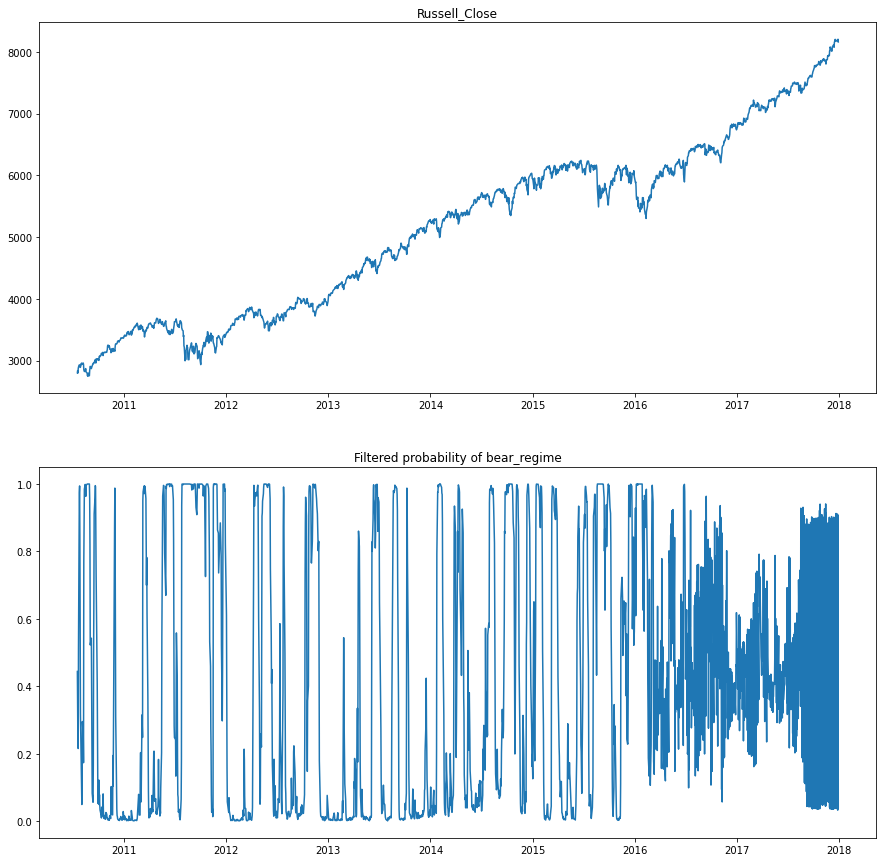

In [97]:
plotProb_train(hmm2_results)

In [98]:
pd.options.mode.use_inf_as_na = True
df_test.columns[df_test.isna().any()].tolist()

[]

In [99]:
df_test_tvtp = df_test.drop( columns= ['hmm1 smoothed state','Ret_1MTBill','Ret_T10Y3M', 'Ret_T10Y2Y','POS_RET','POS_SR','State_RET_shifted','State_SR_shifted'])
df_test_tvtp = df_test_tvtp.dropna()

df_test_tvtp = (df_test_tvtp-mean)/std
df_test_tvtp['ones'] = 1

df_test_tvtp

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  """


,Russell_Close,Russell_Volume,1MTBill,3MTBill,6MTBill,1YTBill,3YTNotes,5YTNotes,10YTNotes,30YTTreasury,T10Y3M,T10Y2Y,3M_USD_LIBOR,TEDRATE,Fed_eff_Rate,WTI_Futures,WTI_Spot,non-farm payroll calendar,change in total non-farm(in thousands),CPI calendar,CPI monthly percent change(%),unemployment rate calendar,Unemployment rate(%),GDP calendar,GDP quarterly percent change(%),Mkt-RF,SMB,HML,RF,FG Close,FG INDEX,SP500_Close,SP500_Volume,Ret_Russell_Close,Ret_3MTBill,Ret_6MTBill,Ret_1YTBill,Ret_3YTNotes,Ret_5YTNotes,Ret_10YTNotes,...,lag80_Ret_WTI_Futures,lag80_Ret_WTI_Spot,lag80_Ret_SP500_Close,lag80_Ret_SP500_Volume,lag100_Ret_Russell_Close,lag100_Ret_1MTBill,lag100_Ret_3MTBill,lag100_Ret_6MTBill,lag100_Ret_1YTBill,lag100_Ret_3YTNotes,lag100_Ret_5YTNotes,lag100_Ret_10YTNotes,lag100_Ret_30YTTreasury,lag100_Ret_T10Y3M,lag100_Ret_T10Y2Y,lag100_Ret_3M_USD_LIBOR,lag100_Ret_WTI_Futures,lag100_Ret_WTI_Spot,lag100_Ret_SP500_Close,lag100_Ret_SP500_Volume,lag120_Ret_Russell_Close,lag120_Ret_1MTBill,lag120_Ret_3MTBill,lag120_Ret_6MTBill,lag120_Ret_1YTBill,lag120_Ret_3YTNotes,lag120_Ret_5YTNotes,lag120_Ret_10YTNotes,lag120_Ret_30YTTreasury,lag120_Ret_T10Y3M,lag120_Ret_T10Y2Y,lag120_Ret_3M_USD_LIBOR,lag120_Ret_WTI_Futures,lag120_Ret_WTI_Spot,lag120_Ret_SP500_Close,lag120_Ret_SP500_Volume,log_ret,hmm1 filtered state,log_ret_MA15,ones
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-02,2.183152,-0.272284,3.780872,3.761756,3.663515,3.781166,2.902893,1.965375,0.383445,-0.663087,-1.793045,-1.932208,3.413806,-0.057967,3.640708,-0.607737,-0.605843,-0.223484,0.091106,-0.222163,0.748078,-0.223484,-1.480772,-0.183582,1.077583,0.859072,0.680191,-0.485523,3.730054,-0.728566,0.228152,2.153099,-0.387170,-0.838688,-0.057531,-0.241713,-0.586187,-0.420077,-0.547457,-0.965842,...,-1.134742,-1.136655,1.811401,-0.456235,1.916137,4.452089,3.923154,3.621492,3.226125,1.784073,0.845296,-0.161623,-0.722848,-1.645825,-1.483748,3.120553,-1.138100,-1.132379,1.878236,-0.530449,1.912659,4.628561,4.354742,3.845933,3.384817,1.892112,0.965745,-0.057158,-0.641281,-1.503639,-1.388867,3.313660,-1.333419,-1.336267,1.850496,-0.704743,0.839529,0.614624,0.299251,1
2018-01-03,2.217319,-0.285778,3.890406,3.736579,3.746943,3.815724,2.902893,1.946651,0.356195,-0.712681,-1.775986,-2.000937,3.410950,0.220693,3.640708,-0.555627,-0.547525,-0.223484,0.091106,-0.222163,0.748078,-0.223484,-1.480772,-0.183582,1.077583,0.576092,-0.742601,-0.378352,3.730054,-0.534870,0.691730,2.194236,-0.154521,-0.574086,-0.032013,-0.203824,-0.141252,-0.012303,0.086498,0.217968,...,-1.202403,-1.201809,1.802348,-0.517170,1.835360,4.482788,3.909842,3.653224,3.244155,1.731909,0.772479,-0.256097,-0.802276,-1.694993,-1.553338,3.120335,-1.179218,-1.181986,1.789465,-0.160000,1.922593,4.674319,4.320368,3.880105,3.446131,1.961141,1.004744,-0.011299,-0.588926,-1.471288,-1.388867,3.312589,-1.308229,-1.308080,1.861925,-0.826764,0.572501,0.614624,0.401067,1
2018-01-04,2.239708,-0.040041,3.819739,3.752315,3.755574,3.844965,2.966442,2.014527,0.362484,-0.710910,-1.741869,-2.000937,3.433451,0.220693,3.640708,-0.539911,-0.542975,-0.223484,0.091106,-0.222163,0.748078,-0.223484,-1.480772,-0.183582,1.077583,0.391067,-0.528208,0.500447,3.730054,-0.388227,1.276937,2.220302,0.058026,-0.355084,-0.044805,-0.055619,-0.120551,-0.270493,-0.370197,-0.070172,...,-1.177608,-1.179531,1.868161,-0.529880,1.844043,4.390691,3.887654,3.601660,3.190066,1.635818,0.710695,-0.266998,-0.782824,-1.678604,-1.518543,3.141688,-1.169468,-1.170114,1.797174,-0.705762,1.947071,4.588522,4.320368,3.858747,3.426970,1.939052,0.954912,-0.032465,-0.584167,-1.487464,-1.388867,3.312589,-1.288588,-1.284164,1.890472,-1.215342,0.351987,0.614624,0.494255,1
2018-01-05,2.277646,-0.410901,3.809139,3.736579,3.732559,3.799774,3.022365,2.044954,0.412791,-0.675485,-1.690693,-1.983755,3.433793,0.406467,3.640708,-0.563485,-0.558278,4.472196,-0.092434,-0.222163,0.748078,4.472196,-1.480772,-0.183582,1.077583,0.652279,-0.684130,-0.528391,3.7300

In [100]:
principalComponents = pca.transform(df_test_tvtp)
principalDf_test = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2','principal component 3','principal component 4','principal component 5'])
principalDf_test

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5
0,31.984273,9.160452,8.524172,-3.801492,0.025792
1,32.191936,9.224347,8.668929,-3.963239,1.128073
2,32.324293,9.375899,8.651910,-3.985063,1.246998
3,32.425702,9.571406,8.670801,-3.836229,0.943853
4,32.571268,9.815191,8.760846,-3.625691,1.367933
...,...,...,...,...,...
745,12.745378,-20.431972,-10.453722,-8.325959,1.306609
746,12.969190,-20.499481,-10.767105,-8.616221,0.824662
747,13.026947,-20.561370,-10.957671,-8.584388,1.407322
748,12.796477,-20.143324,-10.556973,-9.369412,2.109347


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


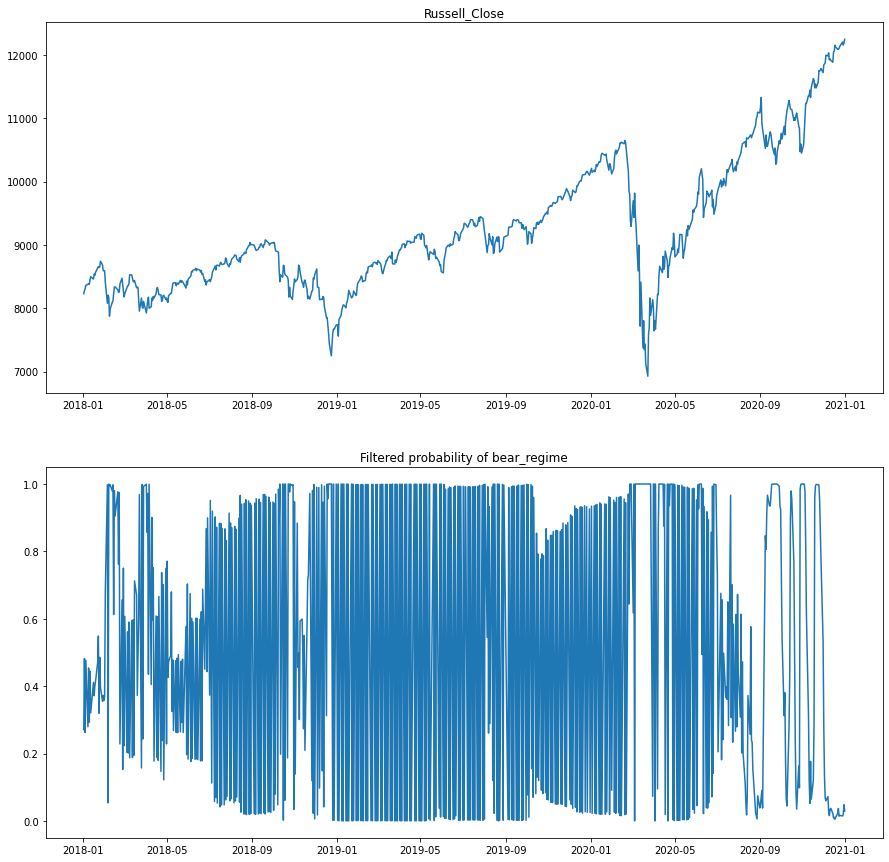

In [101]:
#using the same probability filter constructed from the training set
hmm2_test = sm.tsa.MarkovRegression(endog=df_test[name], k_regimes=2,trend='c',exog_tvtp = principalDf_test,
                                    switching_variance=True)
hmm2_test_results = hmm2_test.fit(start_params = hmm2_results.params, maxiter = 0)
plotProb_test(hmm2_test_results)

In [102]:
t1,t2 = Search_train(hmm2_results, duration_static, duration_bear)
print(t1,t2)

0.99 0.52


In [103]:
label_filtered = labeling(hmm2_results,t1,t2)
print((duration(label_filtered))[0].mean())
print((duration(label_filtered))[1].mean())
print((duration(label_filtered))[2].mean())
print((duration(label_filtered))[3])
print(df_train['log_ret'].sum(), label_train_logret(label_filtered))

0    5.968586
dtype: float64
0    2.177215
dtype: float64
0    4.387755
dtype: float64
476
1.0563283531096594 1.9554236602162467


In [104]:
np.histogram(label_filtered)

(array([ 215,    0,    0,    0,    0,  516,    0,    0,    0, 1139]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]))

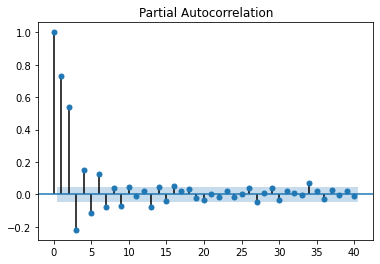

array([ 1.00000000e+00,  7.31563008e-01,  5.39121466e-01, -2.18627561e-01,
        1.53368926e-01, -1.11734597e-01,  1.26620165e-01, -7.84576198e-02,
        4.04572625e-02, -6.83134499e-02,  4.50315164e-02, -8.59615181e-03,
        2.12680117e-02, -7.80861719e-02,  4.32862445e-02, -4.21468090e-02,
        5.03358718e-02,  2.06543891e-02,  3.32870275e-02, -1.91495875e-02,
       -3.55949494e-02,  7.42091719e-04, -1.79482627e-02,  1.90492093e-02,
       -1.52089476e-02,  3.04895675e-03,  4.01505074e-02, -4.83495127e-02,
        1.05187680e-02,  3.88089376e-02, -3.21326513e-02,  2.22709313e-02,
        1.01395432e-02, -2.30473490e-03,  6.86831064e-02,  1.84623587e-02,
       -2.51474145e-02,  2.70313071e-02, -3.47310241e-04,  1.98069350e-02,
       -9.23366043e-03])

In [105]:
sm.graphics.tsa.plot_pacf(label_filtered, lags=40)
plt.show()
sm.tsa.pacf(label_filtered)

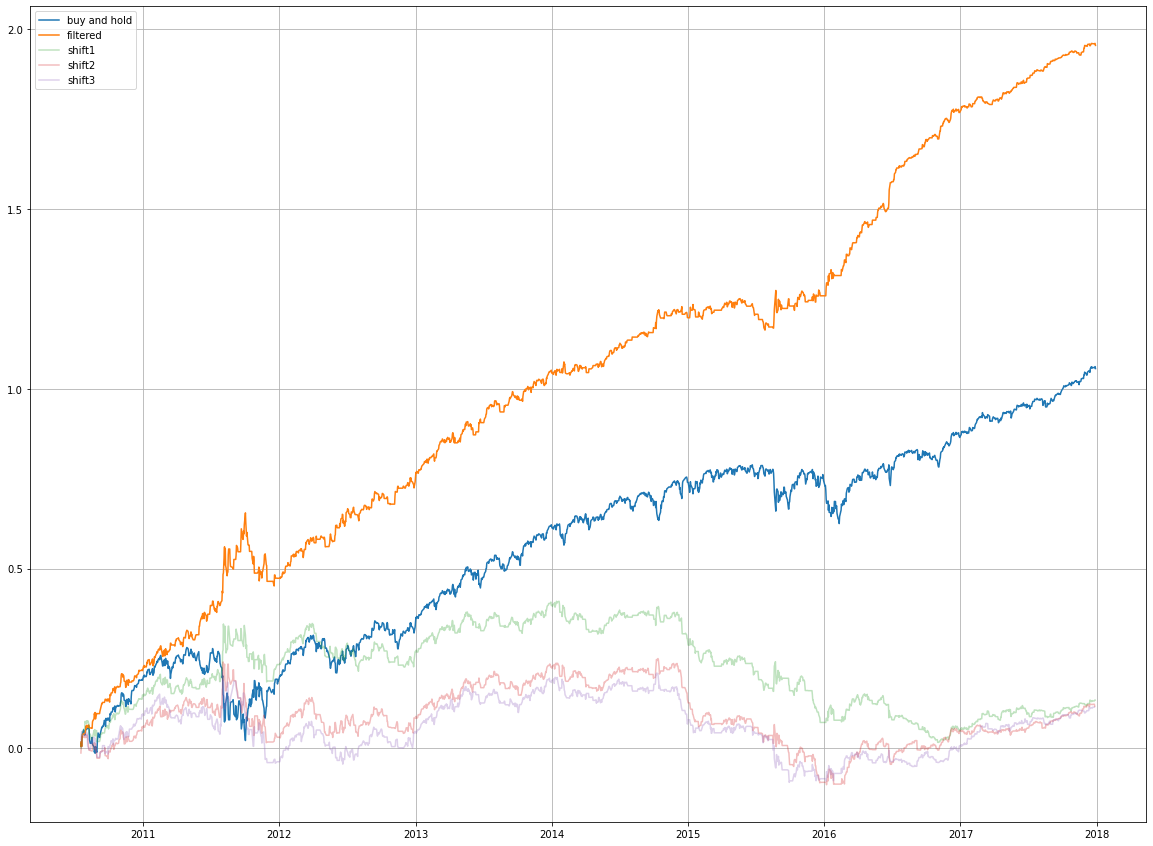

In [106]:
# training set plot

fig, ax = plt.subplots(figsize=(20, 15))

#ax.plot(df_train.index, np.abs(df_train['log_ret']).cumsum(),label="best")
ax.plot(df_train.index, df_train['log_ret'].cumsum(),label="buy and hold")
ax.plot(df_train.index, (df_train['log_ret'] * label_filtered).cumsum(),label = "filtered")
ax.plot(df_train.index, (df_train['log_ret'].shift(-1) * label_filtered).cumsum(),label = "shift1",alpha=0.3)
ax.plot(df_train.index, (df_train['log_ret'].shift(-2) * label_filtered).cumsum(),label = "shift2",alpha=0.3)
ax.plot(df_train.index, (df_train['log_ret'].shift(-3) * label_filtered).cumsum(),label = "shift3",alpha=0.3)
ax.grid(True)
ax.legend()

plt.show()

In [107]:
label_filtered = labeling(hmm2_test_results,t1,t2)
print((duration(label_filtered))[0].mean())
print((duration(label_filtered))[1].mean())
print((duration(label_filtered))[2].mean())
print((duration(label_filtered))[3])
print(df_test['log_ret'].sum(), label_test_logret(label_filtered))

0    1.372694
dtype: float64
0    1.207317
dtype: float64
0    1.340741
dtype: float64
569
0.3971813455377167 1.2948939102791406


In [108]:
np.histogram(label_filtered)

(array([181,   0,   0,   0,   0, 198,   0,   0,   0, 371]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]))

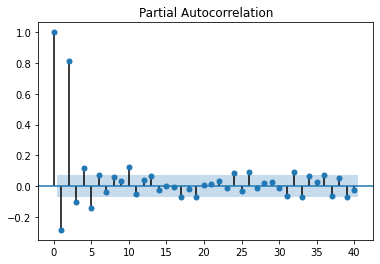

array([ 1.        , -0.28356977,  0.81222959, -0.10258629,  0.11702025,
       -0.13964134,  0.07269336, -0.03677883,  0.05839217,  0.03093912,
        0.12373188, -0.05355649,  0.03807005,  0.06842574, -0.02119809,
        0.00395523, -0.00214966, -0.06717432, -0.01579694, -0.0704063 ,
        0.01006356,  0.01310845,  0.0369296 , -0.01339886,  0.08282514,
       -0.03075662,  0.09502022, -0.01432962,  0.02107446,  0.02813797,
       -0.01427537, -0.06028456,  0.09019824, -0.07255767,  0.06916881,
        0.02778574,  0.07616505, -0.06315307,  0.05195442, -0.07169492,
       -0.0233529 ])

In [109]:
sm.graphics.tsa.plot_pacf(label_filtered, lags=40)
plt.show()
sm.tsa.pacf(label_filtered)

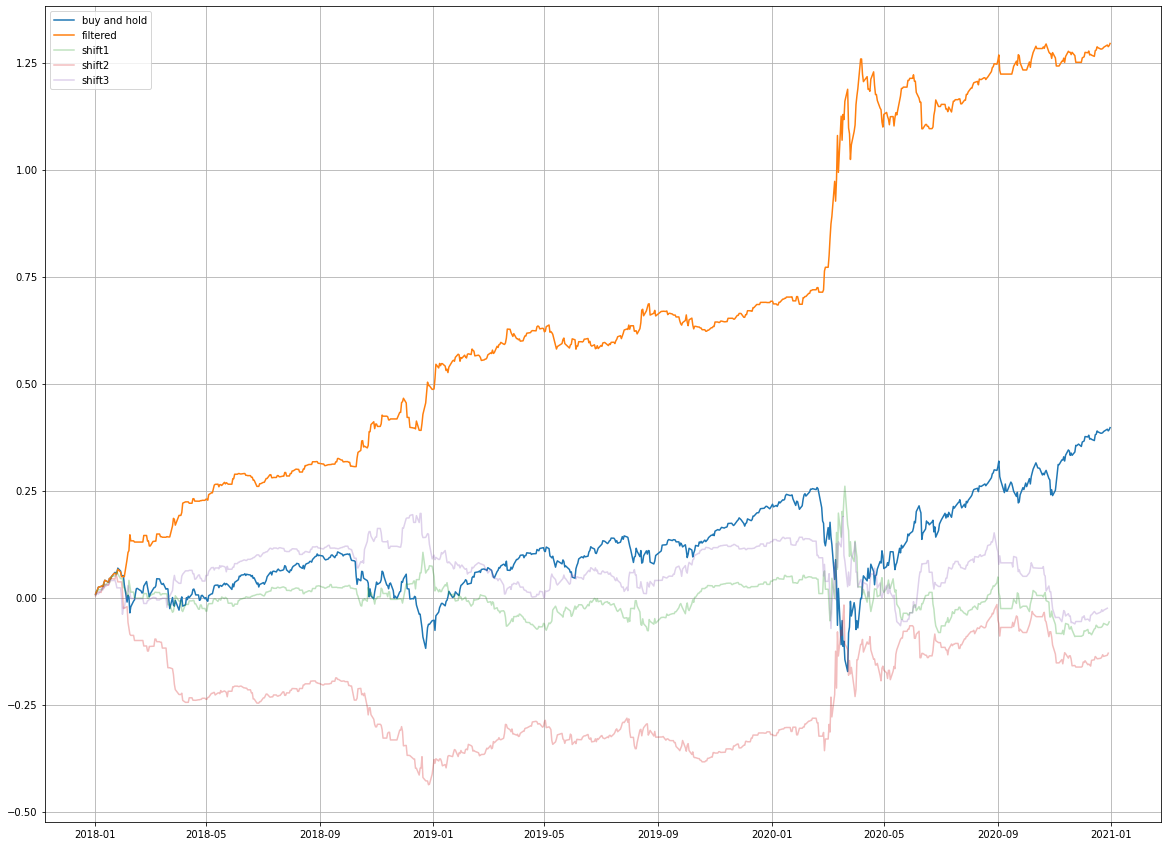

In [110]:
# testing set plot

fig, ax = plt.subplots(figsize=(20, 15))

ax.plot(df_test.index, df_test['log_ret'].cumsum(),label="buy and hold")
ax.plot(df_test.index, (df_test['log_ret'] * label_filtered).cumsum(),label = "filtered")
ax.plot(df_test.index, (df_test['log_ret'].shift(-1) * label_filtered).cumsum(),label = "shift1",alpha=0.3)
ax.plot(df_test.index, (df_test['log_ret'].shift(-2) * label_filtered).cumsum(),label = "shift2",alpha=0.3)
ax.plot(df_test.index, (df_test['log_ret'].shift(-3) * label_filtered).cumsum(),label = "shift3",alpha=0.3)
ax.grid(True)
ax.legend()

plt.show()

## Two regimes, switching mean and variance with other dependent variables in transition prob. and mean.

In [111]:
# switching mean dependent variabels
df_train_exog = df_train[['SMB','HML']]
df_test_exog = df_test[['SMB','HML']]

In [112]:
hmm3 = sm.tsa.MarkovRegression(endog=df_train[name], k_regimes=2,trend='c', exog = df_train_exog, 
                               exog_tvtp = principalDf_train, switching_exog = True, switching_variance=True)
hmm3_results = hmm3.fit(search_reps = 100)
print(hmm3_results.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                        Markov Switching Model Results                        
Dep. Variable:           log_ret_MA15   No. Observations:                 1870
Model:               MarkovRegression   Log Likelihood                9237.620
Date:                Wed, 09 Feb 2022   AIC                         -18439.241
Time:                        19:55:16   BIC                         -18339.634
Sample:                             0   HQIC                        -18402.543
                               - 1870                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001      0.000      0.700      0.484      -0.000       0.000
x1             0.0005      0.000      2.826      0.0

In [113]:
t1,t2 = Search_train(hmm3_results, duration_static, duration_bear)
print(t1,t2)

1.0 0.96


In [114]:
label_filtered = labeling(hmm3_results,t1,t2)
print((duration(label_filtered))[0].mean())
print((duration(label_filtered))[1].mean())
print((duration(label_filtered))[2].mean())
print((duration(label_filtered))[3])
print(df_train['log_ret'].sum(), label_train_logret(label_filtered))

0    26.583333
dtype: float64
0    4.393443
dtype: float64
0    4.0
dtype: float64
122
1.0563283531096594 1.528610583489507


In [115]:
np.histogram(label_filtered)

(array([   8,    0,    0,    0,    0,  268,    0,    0,    0, 1594]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]))

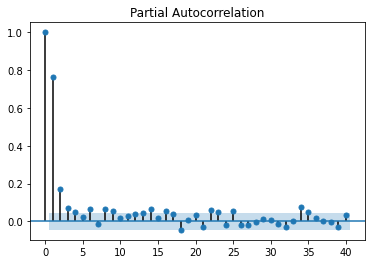

array([ 1.00000000e+00,  7.62842502e-01,  1.72483450e-01,  6.89406228e-02,
        4.78686903e-02,  2.41727929e-02,  6.54052742e-02, -1.37284026e-02,
        6.72067759e-02,  5.32103326e-02,  1.76103024e-02,  2.71670142e-02,
        3.71690789e-02,  4.65257664e-02,  6.32250827e-02,  1.82572223e-02,
        5.36210232e-02,  3.63897793e-02, -4.43215512e-02,  5.22899816e-03,
        3.18354349e-02, -3.11861339e-02,  5.86827499e-02,  5.12134848e-02,
       -1.91382229e-02,  5.36884317e-02, -2.08539724e-02, -1.73062050e-02,
       -3.64898969e-03,  1.40852023e-02,  9.51474859e-03, -1.14065203e-02,
       -2.73154935e-02,  3.78806134e-03,  7.73103536e-02,  4.88109785e-02,
        1.85944034e-02,  9.01677009e-05, -5.36451025e-03, -2.84788780e-02,
        3.40188397e-02])

In [116]:
sm.graphics.tsa.plot_pacf(label_filtered, lags=40)
plt.show()
sm.tsa.pacf(label_filtered)

In [117]:
hmm3_test = sm.tsa.MarkovRegression(endog=df_test[name], k_regimes=2,trend='c', exog = df_test_exog, 
                               exog_tvtp = principalDf_test, switching_exog = True,switching_variance=True)
hmm3_test_results = hmm3_test.fit(start_params = hmm3_results.params, maxiter = 0)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [118]:
label_filtered = labeling(hmm3_test_results,t1,t2)
print((duration(label_filtered))[0].mean())
print((duration(label_filtered))[1].mean())
print((duration(label_filtered))[2].mean())
print((duration(label_filtered))[3])
print(df_test['log_ret'].sum(), label_test_logret(label_filtered))

0    16.74359
dtype: float64
0    2.05
dtype: float64
0    4.0
dtype: float64
82
0.3971813455377167 0.9216068545083818


In [119]:
np.histogram(label_filtered)

(array([ 16,   0,   0,   0,   0,  82,   0,   0,   0, 652]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]))

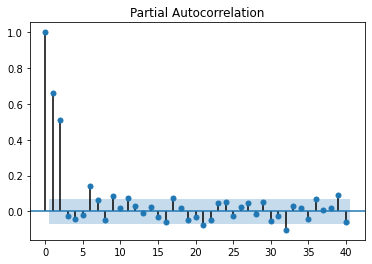

array([ 1.        ,  0.65874403,  0.50850206, -0.02372349, -0.03946801,
       -0.02003764,  0.14092283,  0.06156453, -0.04822285,  0.08517559,
        0.0169512 ,  0.07263489,  0.02992193, -0.00761956,  0.02512215,
       -0.03246581, -0.05773505,  0.07693874,  0.02022429, -0.04847059,
       -0.03194892, -0.07518103, -0.04715149,  0.04898   ,  0.05046486,
       -0.02806764,  0.02422279,  0.04766524, -0.01680636,  0.05325862,
       -0.05393894, -0.02594528, -0.1030237 ,  0.02778591,  0.01974601,
       -0.04277038,  0.06931255,  0.00577769,  0.01786877,  0.09167606,
       -0.06116283])

In [120]:
sm.graphics.tsa.plot_pacf(label_filtered, lags=40)
plt.show()
sm.tsa.pacf(label_filtered)

## Two regimes, switching mean and variance with other dependent variables in mean.

In [121]:
hmm4 = sm.tsa.MarkovRegression(endog=df_train[name], k_regimes=2,trend='c', exog = df_train_exog, 
                                switching_exog = True,switching_variance=True)
hmm4_results = hmm4.fit(search_reps = 100)
print(hmm4_results.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                        Markov Switching Model Results                        
Dep. Variable:           log_ret_MA15   No. Observations:                 1870
Model:               MarkovRegression   Log Likelihood                9405.784
Date:                Wed, 09 Feb 2022   AIC                         -18791.569
Time:                        19:55:43   BIC                         -18736.232
Sample:                             0   HQIC                        -18771.181
                               - 1870                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0009      0.000     -2.951      0.003      -0.002      -0.000
x1             0.0005      0.000      3.337      0.0

In [122]:
t1,t2 = Search_train(hmm4_results, duration_static, duration_bear)
print(t1,t2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:112: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


0.99 0.88


In [123]:
label_filtered = labeling(hmm4_results,t1,t2)
print((duration(label_filtered))[0].mean())
print((duration(label_filtered))[1].mean())
print((duration(label_filtered))[2].mean())
print((duration(label_filtered))[3])
print(df_train['log_ret'].sum(), label_train_logret(label_filtered))

0    22.080645
dtype: float64
0    2.038835
dtype: float64
0    4.709677
dtype: float64
226
1.0563283531096594 1.8638701839772676


In [124]:
np.histogram(label_filtered)

(array([ 292,    0,    0,    0,    0,  210,    0,    0,    0, 1368]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]))

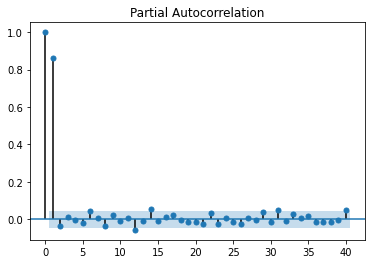

array([ 1.        ,  0.86290296, -0.03651053,  0.013777  , -0.00437409,
       -0.02158116,  0.04282349,  0.00796599, -0.03787881,  0.02067976,
       -0.00766108,  0.00525799, -0.05672593, -0.01141797,  0.05575423,
       -0.0074216 ,  0.0140266 ,  0.02236831, -0.00110096, -0.01607474,
       -0.01657584, -0.02768198,  0.03474012, -0.02562191,  0.00495573,
       -0.01370235, -0.02771167,  0.00664513, -0.00403224,  0.04080346,
       -0.01611753,  0.05206917, -0.00834298,  0.02829669,  0.00943987,
        0.01543984, -0.01416447, -0.01411163, -0.01648297, -0.00519084,
        0.04860777])

In [125]:
sm.graphics.tsa.plot_pacf(label_filtered, lags=40)
plt.show()
sm.tsa.pacf(label_filtered)

In [126]:
hmm4_test = sm.tsa.MarkovRegression(endog=df_test[name], k_regimes=2,trend='c', exog = df_test_exog, 
                                switching_exog = True,switching_variance=True)
hmm4_test_results = hmm4_test.fit(start_params = hmm4_results.params, maxiter = 0)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [127]:
label_filtered = labeling(hmm4_test_results,t1,t2)
print((duration(label_filtered))[0].mean())
print((duration(label_filtered))[1].mean())
print((duration(label_filtered))[2].mean())
print((duration(label_filtered))[3])
print(df_test['log_ret'].sum(), label_test_logret(label_filtered))

0    20.653846
dtype: float64
0    1.233333
dtype: float64
0    7.08
dtype: float64
80
0.3971813455377167 0.6234593930723527


In [128]:
np.histogram(label_filtered)

(array([177,   0,   0,   0,   0,  37,   0,   0,   0, 536]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]))

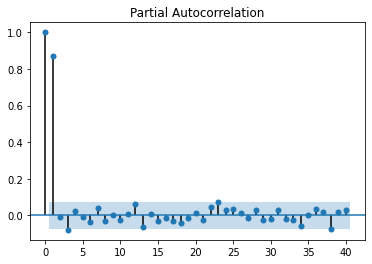

array([ 1.00000000e+00,  8.71307427e-01, -8.65054765e-03, -7.87661382e-02,
        2.59544399e-02, -7.03824473e-03, -3.47585274e-02,  4.24890312e-02,
       -3.23395085e-02,  1.57591514e-04, -2.30367834e-02,  1.02322084e-02,
        6.30312391e-02, -6.27925652e-02,  1.01481621e-02, -2.82695853e-02,
       -1.60528177e-02, -2.78281686e-02, -4.37150199e-02, -1.32598942e-02,
        1.24895982e-02, -2.59085213e-02,  4.83947992e-02,  7.47446679e-02,
        2.88970918e-02,  3.53374852e-02,  1.32269444e-02, -1.36909159e-02,
        2.77287065e-02, -2.28466540e-02, -1.95979093e-02,  2.91546159e-02,
       -1.81942756e-02, -2.50787806e-02, -5.96479151e-02,  7.39563798e-04,
        3.60054291e-02,  2.08343378e-02, -7.52630778e-02,  1.78899996e-02,
        3.02167794e-02])

In [129]:
sm.graphics.tsa.plot_pacf(label_filtered, lags=40)
plt.show()
sm.tsa.pacf(label_filtered)

In [130]:
hmm5 = sm.tsa.MarkovRegression(endog=df_train[name], k_regimes=2,trend='c', exog = principalDf_train, 
                                switching_exog = True,switching_variance=True)
hmm5_results = hmm5.fit(search_reps = 100)
print(hmm5_results.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/regime_switching/markov_switching.py:1144: RuntimeWarning: divide by zero encountered in log
  return np.log(results[5])
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/regime_switching/markov_switching.py:1144: RuntimeWarning: divide by zero encountered in log
  return np.log(results[5])
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                        Markov Switching Model Results                        
Dep. Variable:           log_ret_MA15   No. Observations:                 1870
Model:               MarkovRegression   Log Likelihood                9554.049
Date:                Wed, 09 Feb 2022   AIC                         -19076.098
Time:                        19:56:06   BIC                         -18987.559
Sample:                             0   HQIC                        -19043.478
                               - 1870                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       7.452e-05      0.000      0.548      0.583      -0.000       0.000
x1           4.06e-05   1.54e-05      2.634      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:1286: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))


This model labels the observables from a perspective fairly different from bear and bull concept.

In [131]:
t1,t2 = Search_train(hmm5_results, duration_static, duration_bear)
print(t1,t2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:112: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


1.0 0.99


In [132]:
label_filtered = labeling(hmm4_results,t1,t2)
print((duration(label_filtered))[0].mean())
print((duration(label_filtered))[1].mean())
print((duration(label_filtered))[2].mean())
print((duration(label_filtered))[3])
print(df_train['log_ret'].sum(), label_train_logret(label_filtered))

0    25.063492
dtype: float64
0    4.4375
dtype: float64
0    4.0
dtype: float64
128
1.0563283531096594 1.7805277698147826


In [133]:
np.histogram(label_filtered)

(array([   8,    0,    0,    0,    0,  284,    0,    0,    0, 1578]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]))

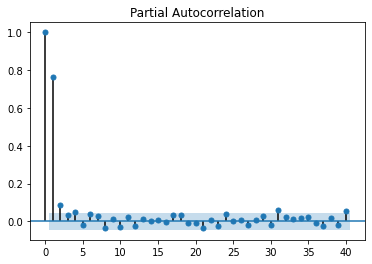

array([ 1.00000000e+00,  7.61390694e-01,  8.62233870e-02,  3.25027046e-02,
        5.05799863e-02, -1.79839159e-02,  3.82055057e-02,  2.76575422e-02,
       -3.54568864e-02,  1.11321071e-02, -2.98796958e-02,  2.41059358e-02,
       -2.21580325e-02,  1.04118030e-02,  1.04704872e-03,  9.59766460e-03,
       -3.39535709e-03,  3.17487744e-02,  3.23863506e-02, -9.19902842e-03,
       -8.39676133e-03, -3.72251598e-02,  7.75495319e-03, -2.69031528e-02,
        3.78897762e-02,  6.98413038e-04,  8.45278140e-03, -2.14546399e-02,
        4.82571779e-03,  2.74948465e-02, -1.82747687e-02,  6.19185377e-02,
        2.17842263e-02,  1.47794459e-02,  1.87895597e-02,  2.29536712e-02,
       -6.96980726e-03, -2.46537614e-02,  1.53484259e-02, -1.99123398e-02,
        5.41200214e-02])

In [134]:
sm.graphics.tsa.plot_pacf(label_filtered, lags=40)
plt.show()
sm.tsa.pacf(label_filtered)

In [135]:
hmm5_test = sm.tsa.MarkovRegression(endog=df_test[name], k_regimes=2,trend='c', exog = principalDf_test, 
                                switching_exog = True, switching_variance=True)
hmm5_test_results = hmm5_test.fit(start_params = hmm5_results.params, maxiter = 0)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [136]:
label_filtered = labeling(hmm4_test_results,t1,t2)
print((duration(label_filtered))[0].mean())
print((duration(label_filtered))[1].mean())
print((duration(label_filtered))[2].mean())
print((duration(label_filtered))[3])
print(df_test['log_ret'].sum(), label_test_logret(label_filtered))

0    22.076923
dtype: float64
0    4.966667
dtype: float64
0    4.666667
dtype: float64
61
0.3971813455377167 0.8801003973176458


In [137]:
np.histogram(label_filtered)

(array([ 28,   0,   0,   0,   0, 149,   0,   0,   0, 573]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]))

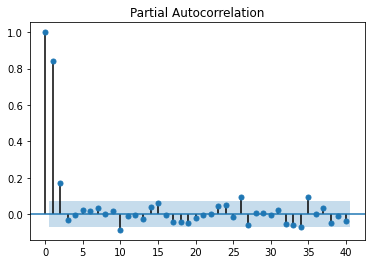

array([ 1.00000000e+00,  8.44638734e-01,  1.70370780e-01, -2.94941508e-02,
       -5.63264108e-03,  2.28537850e-02,  1.80522234e-02,  3.61829120e-02,
        1.09892762e-03,  1.90549790e-02, -8.59320380e-02, -7.54282426e-03,
       -5.75527281e-03, -2.51708789e-02,  3.82508845e-02,  6.31523272e-02,
       -4.11882764e-03, -4.43692088e-02, -4.11981799e-02, -4.89379275e-02,
       -1.98572922e-02, -1.66988635e-03, -9.40477817e-04,  4.40365509e-02,
        5.06232882e-02, -1.39347319e-02,  9.26514597e-02, -6.04493944e-02,
        9.56318891e-03,  6.46318630e-03, -6.33096622e-03,  2.10870440e-02,
       -5.22927331e-02, -6.01628818e-02, -6.91486990e-02,  9.53981081e-02,
        4.14925941e-03,  3.34109496e-02, -4.67778061e-02, -1.11387653e-02,
       -3.62207003e-02])

In [138]:
sm.graphics.tsa.plot_pacf(label_filtered, lags=40)
plt.show()
sm.tsa.pacf(label_filtered)

## Method 1
## Pick thresholds such that the durations meet certain criteria

In [139]:
## some tech issue for this function

#from scipy.optimize import minimize
def FindTresholds(model_train):
  threshold1,threshold2 = 70,30
  label_train_filtered = labeling(model_train,threshold1/100, threshold2/100)
  duration_bear = duration(label)
  duration_bear_mean = duration_bear.mean()
    
  #find threshold1 such that the bear duration reach 4
  while(duration_bear_mean <=4 and threshold1 <=99):
    threshold1+=1
    label_train_filtered = labeling(model_train,threshold1/100, threshold2/100)
    duration_bear = duration(label)
    duration_bear_mean = duration_bear.mean()
    
  #find threshold2 that maximizes log return
  #logret_prev = label_logret(label_train_filtered)
  #for threshold2 in range(30,threshold1):
  #  label_train_filtered = labeling(model_train,threshold1/100, threshold2/100)
  #  logret = logret(label_train_filtered)
  #  if logret < logret_prev:
  #    threshold2-=1
  #    break
  #  logret_prev = logret

  return threshold1/100,threshold2/100


In [140]:
label_filtered = labeling(hmm1_results,0.99,0.89)
print((duration(label_filtered))[0].mean())
print((duration(label_filtered))[1].mean())
print((duration(label_filtered))[2].mean())
print(df_train['log_ret'].sum(), label_train_logret(label_filtered))

0    29.163265
dtype: float64
0    2.525
dtype: float64
0    5.333333
dtype: float64
1.0563283531096594 1.8334174883939829


In [141]:
np.histogram(label_filtered)

(array([ 240,    0,    0,    0,    0,  202,    0,    0,    0, 1428]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]))

In [142]:
label_filtered = labeling(hmm1_test_results,0.99,0.89)
print((duration(label_filtered))[0].mean())
print((duration(label_filtered))[1].mean())
print((duration(label_filtered))[2].mean())
print(df_test['log_ret'].sum(), (df_test['log_ret']*label_filtered).sum())

0    21.84
dtype: float64
0    1.275862
dtype: float64
0    6.461538
dtype: float64
0.3971813455377167 0.5851967881484287


In [143]:
np.histogram(label_filtered)

(array([168,   0,   0,   0,   0,  37,   0,   0,   0, 545]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]))

In [144]:
label_filtered = labeling(hmm2_results,0.99, 0.45)
print((duration(label_filtered))[0].mean())
print((duration(label_filtered))[1].mean())
print((duration(label_filtered))[2].mean())
print(df_train['log_ret'].sum(), label_train_logret(label_filtered))

0    5.075472
dtype: float64
0    2.248062
dtype: float64
0    4.387755
dtype: float64
1.0563283531096594 1.8949839431348667


In [145]:
np.histogram(label_filtered)

(array([ 215,    0,    0,    0,    0,  580,    0,    0,    0, 1075]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]))

In [146]:
label_filtered = labeling(hmm2_test_results,0.99, 0.45)
print((duration(label_filtered))[0].mean())
print((duration(label_filtered))[1].mean())
print((duration(label_filtered))[2].mean())
print(df_test['log_ret'].sum(), (df_test['log_ret']*label_filtered).sum())

0    1.245552
dtype: float64
0    1.257143
dtype: float64
0    1.340741
dtype: float64
0.3971813455377167 1.2290997390292162


In [147]:
np.histogram(label_filtered)

(array([181,   0,   0,   0,   0, 220,   0,   0,   0, 349]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]))

In [148]:
label_filtered = labeling(hmm3_results,0.99, 0.71)
print((duration(label_filtered))[0].mean())
print((duration(label_filtered))[1].mean())
print((duration(label_filtered))[2].mean())
print(df_train['log_ret'].sum(), label_train_logret(label_filtered))

0    18.852941
dtype: float64
0    3.794393
dtype: float64
0    4.255814
dtype: float64
1.0563283531096594 1.2059698977230533


In [149]:
np.histogram(label_filtered)

(array([ 183,    0,    0,    0,    0,  406,    0,    0,    0, 1281]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]))

In [150]:
label_filtered = labeling(hmm3_test_results,0.99, 0.71)
print((duration(label_filtered))[0].mean())
print((duration(label_filtered))[1].mean())
print((duration(label_filtered))[2].mean())
print(df_test['log_ret'].sum(), (df_test['log_ret']*label_filtered).sum())

0    9.28125
dtype: float64
0    1.565217
dtype: float64
0    2.65625
dtype: float64
0.3971813455377167 1.0786979231125233


In [151]:
np.histogram(label_filtered)

(array([ 85,   0,   0,   0,   0,  72,   0,   0,   0, 593]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]))

In [152]:
label_filtered = labeling(hmm4_results,0.99, 0.91)
print((duration(label_filtered))[0].mean())
print((duration(label_filtered))[1].mean())
print((duration(label_filtered))[2].mean())
print(df_train['log_ret'].sum(), label_train_logret(label_filtered))

0    23.2
dtype: float64
0    1.908163
dtype: float64
0    4.709677
dtype: float64
1.0563283531096594 1.9042666376527815


In [153]:
np.histogram(label_filtered)

(array([ 292,    0,    0,    0,    0,  187,    0,    0,    0, 1391]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]))

In [154]:
label_filtered = labeling(hmm4_test_results,0.99, 0.91)
print((duration(label_filtered))[0].mean())
print((duration(label_filtered))[1].mean())
print((duration(label_filtered))[2].mean())
print(df_test['log_ret'].sum(), (df_test['log_ret']*label_filtered).sum())

0    19.962963
dtype: float64
0    1.206897
dtype: float64
0    7.08
dtype: float64
0.3971813455377167 0.6186740679183511


In [155]:
np.histogram(label_filtered)

(array([177,   0,   0,   0,   0,  35,   0,   0,   0, 538]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]))